# Кластеризация ЕГЭ (4 если сделаны все задачи)

Рядом лежат данные с координатами точек. Везде используется Евклидово расстояние. Кластером считается набор не менее чем из 30 точек связанных друг с другом. Аномалия это точка находящаяся на расстоянии более 1 от любого кластера.

* Постройте Распределение точек
* Напишите руками DBSCAN и обработайте им все файлы
* Файл 0.xls также решите руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Отметьте Аномалии отдельным цветом
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите два числа - Среднее абсцисс и ординат центроидов кластеров * 100000

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix, cKDTree
from collections import deque

In [16]:
def parse_pipe_separated(text):
    lines = text.strip().split('\n')
    points = []
    start_idx = 0
    if 'HEAD' in lines[0]:
        start_idx = 1
    for line in lines[start_idx:]:
        parts = line.split('|')
        vals = []
        for p in parts:
            try:
                vals.append(float(p.strip()))
            except ValueError:
                pass
        if len(vals) >= 2:
            points.append([vals[-2], vals[-1]])
    return np.array(points)

def parse_csv_separated(text):
    lines = text.strip().split('\n')
    points = []
    for line in lines:
        parts = line.split(',')
        if len(parts) >= 2:
            try:
                x = float(parts[0].strip())
                y = float(parts[1].strip())
                points.append([x, y])
            except ValueError:
                continue
    return np.array(points)

def manual_dbscan(points, eps=1.0, min_samples=30):
    n = len(points)
    labels = np.full(n, -1, dtype=int)
    cluster_id = 0
    
    tree = cKDTree(points)
    neighbors_list = tree.query_ball_point(points, eps)
    
    for i in range(n):
        if labels[i] != -1:
            continue
            
        neighbors = neighbors_list[i]
        
        if len(neighbors) < min_samples:
            continue 
        
        labels[i] = cluster_id
        queue = deque(neighbors)
        queue.remove(i) 
        
        while queue:
            current = queue.popleft()
            if labels[current] == -1:
                labels[current] = cluster_id 
                
                current_neighbors = neighbors_list[current]
                
                if len(current_neighbors) >= min_samples:
                    for neighbor in current_neighbors:
                        if labels[neighbor] == -1:
                            queue.append(neighbor)
                            
        cluster_id += 1
    
    return labels

def get_centroids(points, labels):
    unique_labels = set(labels)
    centroids = []
    for label in unique_labels:
        if label == -1: continue
        cluster_points = points[labels == label]
        centroids.append(cluster_points.mean(axis=0))
    return np.array(centroids)

def process_file(points, filename):
    labels = manual_dbscan(points, eps=1.0, min_samples=30)
    
    plt.figure(figsize=(8, 6))
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        
        class_member_mask = (labels == k)
        xy = points[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6 if k != -1 else 10)
    
    plt.title(f'DBSCAN Clustering for {filename}')
    plt.show()
    
    return get_centroids(points, labels)

Файл 0.xls Пропущен.
Файл 1.xls Пропущен.


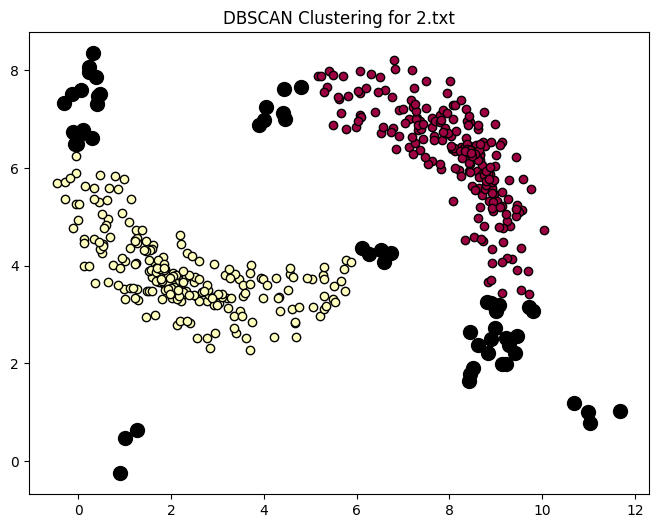

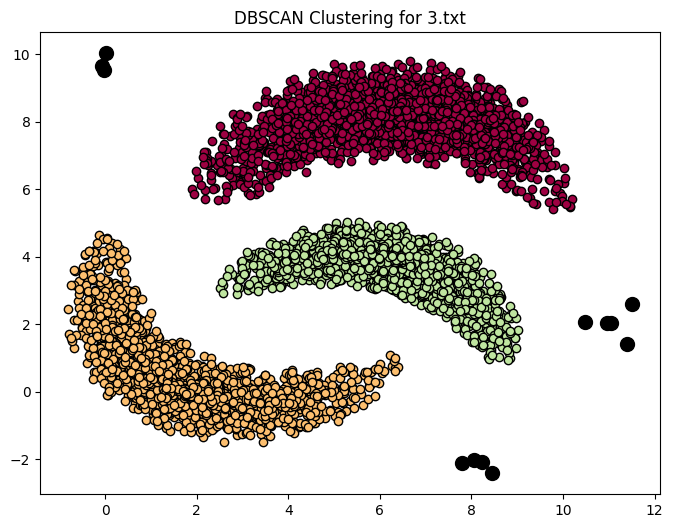

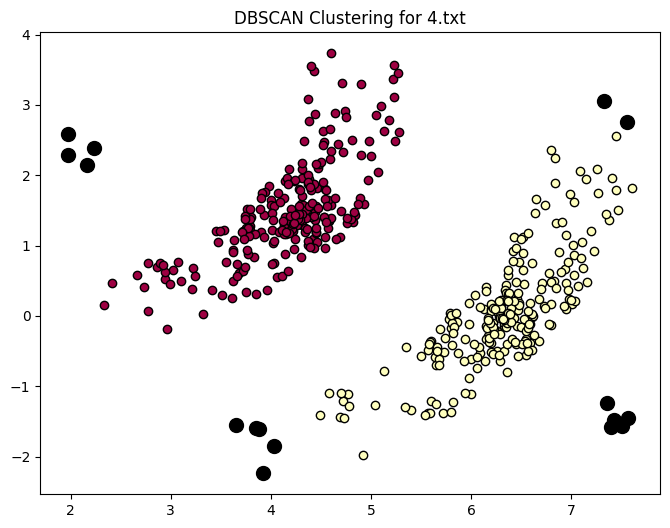

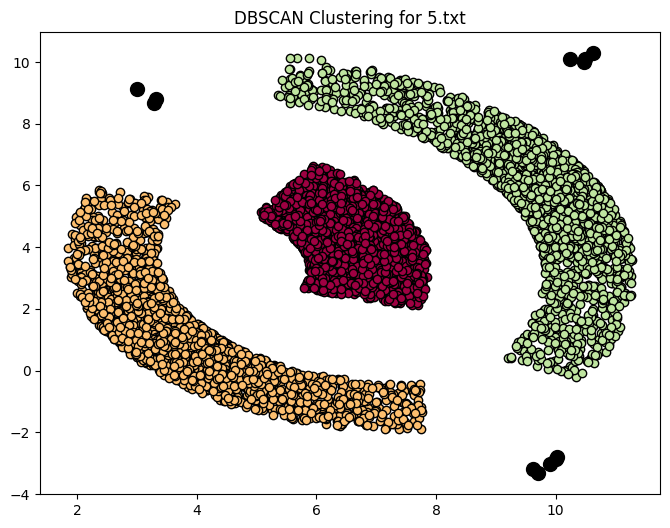

550501, 348573


In [17]:
all_centroids = []
files_to_process = ['0.xls', '1.xls', '2.txt', '3.txt', '4.txt', '5.txt']

for filename in files_to_process:
    try:
        try:
            with open(filename, 'r', encoding='cp1251') as f:
                file_content = f.read()
        except UnicodeDecodeError:
            with open(filename, 'r', encoding='latin-1') as f:
                file_content = f.read()
        
        if filename.endswith('.xls'):
            points = parse_pipe_separated(file_content)
        else:
            points = parse_csv_separated(file_content)
        
        if len(points) == 0:
            print(f"Файл {filename} Пропущен.")
            continue

        current_centroids = process_file(points, filename)
        all_centroids.extend(current_centroids)
        
    except FileNotFoundError:
        print(f"Файл {filename} не найден.")
    except Exception as e:
        print(f"Ошибка при обработке файла {filename}: {e}")

if all_centroids:
    global_mean_centroid = np.mean(all_centroids, axis=0)
    print(f"{int(global_mean_centroid[0] * 100000)}, {int(global_mean_centroid[1] * 100000)}")

# Кластеризация (1 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [18]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [20]:
two_means = cluster.MiniBatchKMeans(n_clusters=3, random_state=42)
dbscan = cluster.DBSCAN(eps=0.3, min_samples=20)
ms = cluster.MeanShift(bandwidth=None, bin_seeding=True)
spectral = cluster.SpectralClustering(n_clusters=3, eigen_solver="arpack", affinity="nearest_neighbors")
ward = cluster.AgglomerativeClustering(n_clusters=3, linkage="ward")
# Заменили affinity на metric
average_linkage = cluster.AgglomerativeClustering(linkage="average", metric="cityblock", n_clusters=3)
optics = cluster.OPTICS(min_samples=20, xi=0.05, min_cluster_size=0.05)
gmm = mixture.GaussianMixture(n_components=3, covariance_type="full")

clustering_algorithms = (
    ("MiniBatch\nKMeans", two_means),
    ("DBSCAN", dbscan),
    ("MeanShift", ms),
    ("Spectral\nClustering", spectral),
    ("Ward", ward),
    ("Agglomerative\nClustering", average_linkage),
    ("OPTICS", optics),
    ("Gaussian\nMixture", gmm),
)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:324: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:324: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


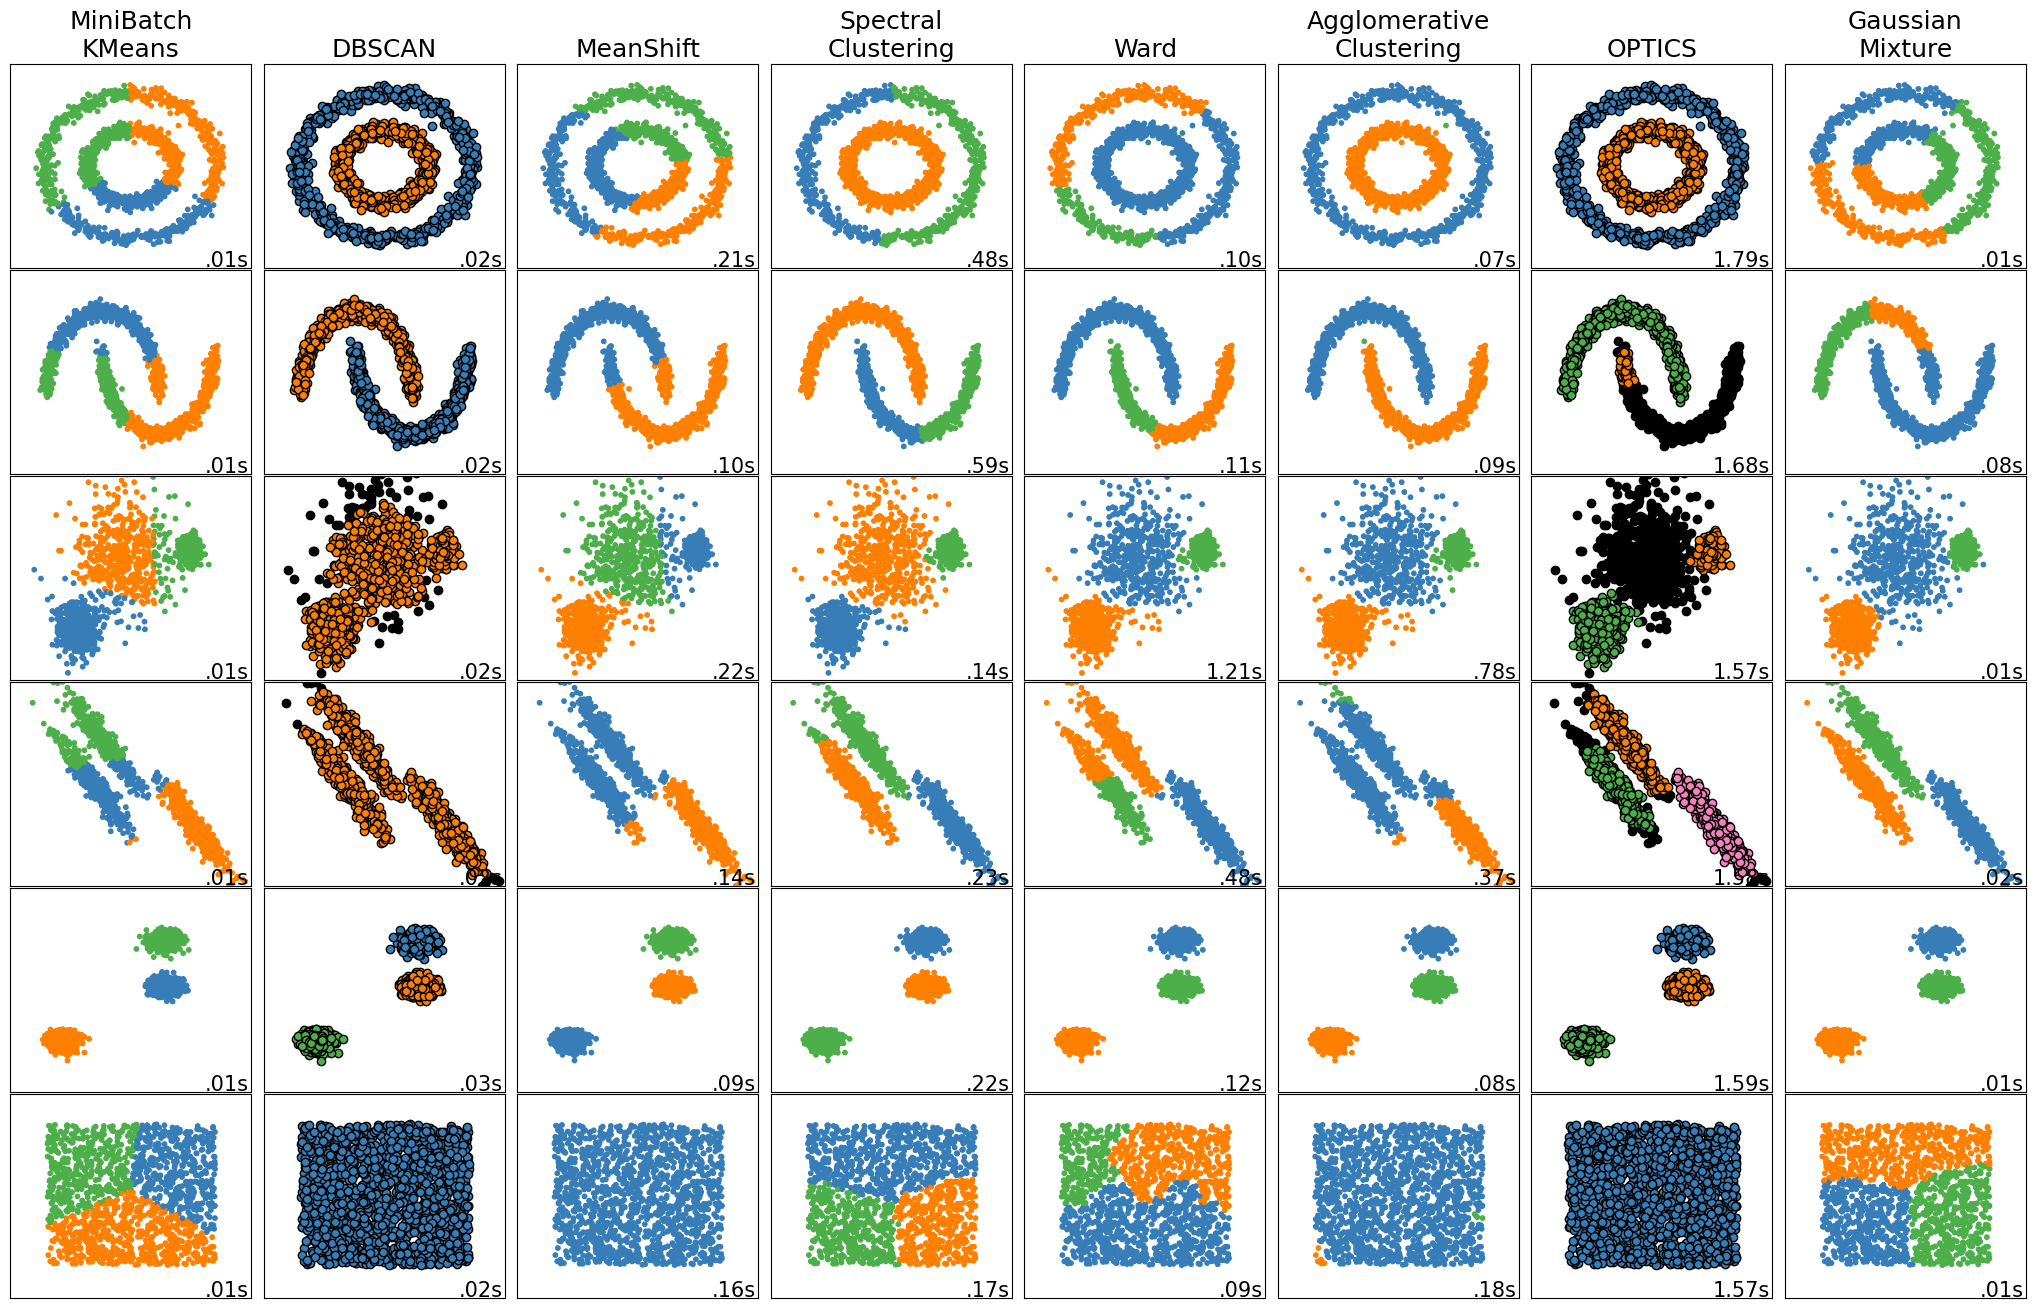

In [22]:
np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

datasets_list = [
    (noisy_circles, {"damping": 0.77, "preference": -240, "quantile": 0.2, "n_clusters": 2, "min_samples": 20, "xi": 0.25}),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (varied, {"eps": 0.18, "n_neighbors": 2, "min_samples": 5, "xi": 0.035, "min_cluster_size": 0.2}),
    (aniso, {"eps": 0.15, "n_neighbors": 2, "min_samples": 20, "xi": 0.1, "min_cluster_size": 0.2}),
    (blobs, {}),
    (no_structure, {}),
]

plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01)
plot_num = 1

default_base = {"quantile": 0.3, "eps": 0.3, "damping": 0.9, "preference": -200, "n_neighbors": 10, "n_clusters": 3, "min_samples": 20, "xi": 0.05, "min_cluster_size": 0.1}

for i_dataset, (dataset, algo_params) in enumerate(datasets_list):
    params = default_base.copy()
    params.update(algo_params)
    X, y = dataset
    X = StandardScaler().fit_transform(X)
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])
    connectivity = kneighbors_graph(X, n_neighbors=params["n_neighbors"], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="the number of connected components.*", category=UserWarning)
            
            if name == "MiniBatch\nKMeans":
                algorithm.fit(X)
                y_pred = algorithm.labels_
            elif name == "MeanShift":
                algorithm.set_params(bandwidth=bandwidth)
                algorithm.fit(X)
                y_pred = algorithm.labels_
            elif name == "Ward":
                algorithm.set_params(connectivity=connectivity)
                y_pred = algorithm.fit_predict(X)
            elif name == "Agglomerative\nClustering":
                algorithm.set_params(connectivity=connectivity)
                y_pred = algorithm.fit_predict(X)
            elif name == "Gaussian\nMixture":
                algorithm.fit(X)
                y_pred = algorithm.predict(X)
            else:
                y_pred = algorithm.fit_predict(X)

        t1 = time.time()
        plt.subplot(len(datasets_list), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00", "#000000"])

        if name == "DBSCAN" or name == "OPTICS":
            y_pred = y_pred.astype(int)
            unique_labels = sorted(set(y_pred))
            for k, col in zip(unique_labels, colors):
                if k == -1:
                    col = [0, 0, 0, 1]
                
                class_member_mask = y_pred == k
                xy = X[class_member_mask]
                plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=col, markeredgecolor="k", markersize=6)
        elif name == "Gaussian\nMixture":
            plt.scatter(X[:, 0], X[:, 1], s=10, c=colors[y_pred])
        else:
            plt.scatter(X[:, 0], X[:, 1], s=10, c=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(0.99, 0.01, ("%.2fs" % (t1 - t0)).lstrip("0"), transform=plt.gca().transAxes, size=15, horizontalalignment="right")
        plot_num += 1

plt.show()